In [23]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [104]:
ProgressMeter.ijulia_behavior(:clear);

In [300]:
# Returns a vector of indices of the codewords of weight w
# Assumes basis BB to have a number of rows multiple of 64
function cws_of_weight_w(BB, w::Int, n::Int; 
        y = falses(n), x = falses(size(BB,2)))
    nn, k = size(BB)
    @assert mod(nn, 64)==0 "nn=$nn"
    cws = typeof(x.chunks[1])[]
    for i in 0:2^k-1
        x.chunks[1] = i 
        bitmult_fast!(y, BB, x)
        d = hamming(y)
        if d == w
            push!(cws, i)
        end
    end
    cws
end

cws_of_weight_w (generic function with 1 method)

In [62]:
function islinearindep(B, v; Baux=[B v])
    gfrcefGF2!(Baux)
    return !all(iszero, Baux[:,end])
end

islinearindep (generic function with 1 method)

In [163]:
function lightest_basis(BB, n::Int; y = falses(n), x = falses(size(BB,2)), showprogress=true)
    nn, k = size(BB)
    @assert mod(nn, 64)==0 "nn=$nn"
    Blight = falses(nn, 0)
    dt = showprogress ? 0.1 : Inf
    prog = ProgressUnknown(desc="Finding lightest basis", dt=dt)
    for w in 1:n
        cws = cws_of_weight_w(BB, w, n; y=y, x=x)
        for c in cws 
            z = bitmult_fast(BB, c)
            # try to add c to the basis
            islinearindep(Blight, z) && (Blight = [Blight z])
            # if basis complete, return
            size(Blight, 2) == k && return Blight, w
        end
        next!(prog, showvalues=[("weight", w)])
    end
    error("Something went wrong")
end

lightest_basis (generic function with 1 method)

In [96]:
n = 80
R = 1 // 4
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
rng = MersenneTwister(4)
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
B, indep = findbasis(H)
B = BitMatrix(B)
BB = augment_basis(B);

In [97]:
Blight, w = lightest_basis(BB, n)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Finding lightest basis 14 	 Time: 0:00:04
  weight:  14

(Bool[0 0 … 1 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 15)

### Basis weight as n increases - RS regime

In [ ]:
R_rs = 1 // 4
ns_rs = 16 .* (1:7)
nsamples_rs = 100
weights_rs = [zeros(Int, nsamples_rs) for _ in ns_rs]
t_rs = @timed begin
    for (j,n) in enumerate(ns_rs)
        println("Size n=$n")
        @threads for k in 1:nsamples_rs
            m = round(Int, n*(1-R_rs))
            f3 = 1-3R_rs
            nedges = 3m 
            Λ = [0,1-f3,f3]
            H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=MersenneTwister(k)))
            B, indep = findbasis_slow(H)
            B = BitMatrix(B)
            BB = augment_basis(B)
            Blight, weights_rs[j][k] = lightest_basis(BB, n)
        end
    end
end

Finding lightest basis 3 	 Time: 0:00:01
Finding lightest basis 3 	 Time: 0:00:01
Finding lightest basis 3 	 Time: 0:00:00
Finding lightest basis 16 	 Time: 0:00:08
Finding lightest basis 14 	 Time: 0:00:05
Finding lightest basis 5 	 Time: 0:00:02
Finding lightest basis 2 	 Time: 0:00:00
Finding lightest basis 3 	 Time: 0:00:01
Finding lightest basis 6 	 Time: 0:00:02
Finding lightest basis 9 	 Time: 0:00:03
Finding lightest basis 11 	 Time: 0:00:04
  weight:  11

In [247]:
t_rs.time / 3600

2.9058095407527778

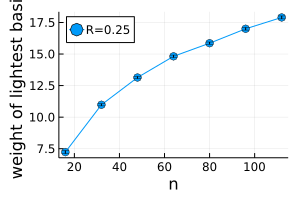

In [250]:
pl_rs = plot(ns_rs, mean.(weights_rs) , err=std.(weights_rs)./sqrt(nsamples_rs), label="R=$(float(R_rs))", m=:o,
    xlabel="n", ylabel="weight of lightest basis", legend=:topleft, size=(300,200))

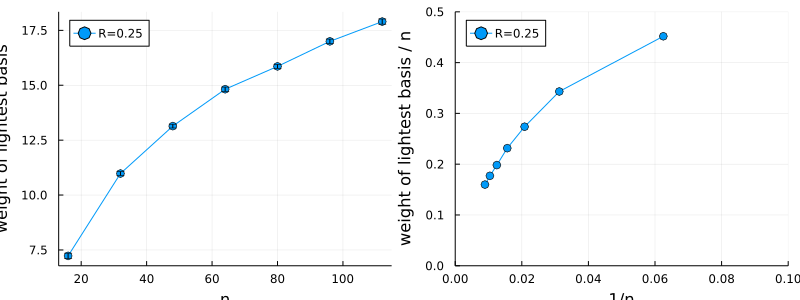

In [259]:
pl_rs2 = plot(1 ./ns_rs, mean.(weights_rs) ./ ns_rs , label="R=$(float(R_rs))", m=:o,
    xlabel="1/n", ylabel="weight of lightest basis / n", legend=:topleft, xlims=(0, 0.1), 
    ylims=(0,0.5))
plot(pl_rs, pl_rs2, size=(800,300))

In [ ]:
A_rs = [log.(ns_rs) ones(length(ns_rs))]
b_rs = mean.(weights_rs)
m_rs, q_rs = A_rs \ b_rs
plot!(pl_rs, ns_rs, m_rs*log.(ns_rs).+q_rs, label="log fit")

In [ ]:
@telegram "Lightest basis"

### Basis weight as n increases - RSB regime

In [ ]:
R_rsb = 3 // 16
ns_rsb = 16 .* (1:9)
nsamples_rsb = 100
weights_rsb = [zeros(Int, nsamples_rsb) for _ in ns_rsb]
for (j,n) in enumerate(ns_rsb)
    println("Size n=$n")
    @threads for k in 1:nsamples_rsb
        m = round(Int, n*(1-R_rsb))
        f3 = 1-3R_rsb
        nedges = 3m 
        Λ = [0,1-f3,f3]
        H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=MersenneTwister(k)))
        B, indep = findbasis_slow(H)
        B = BitMatrix(B)
        BB = augment_basis(B)
        Blight, weights_rsb[j][k] = lightest_basis(BB, n, showprogress=false)
    end
    flush(stdout)
end

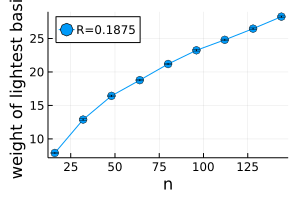

In [254]:
pl_rsb = plot(ns_rsb, mean.(weights_rsb) , err=std.(weights_rsb)./sqrt(nsamples_rsb), label="R=$(float(R_rsb))", m=:o,
    xlabel="n", ylabel="weight of lightest basis", legend=:topleft, size=(300,200))

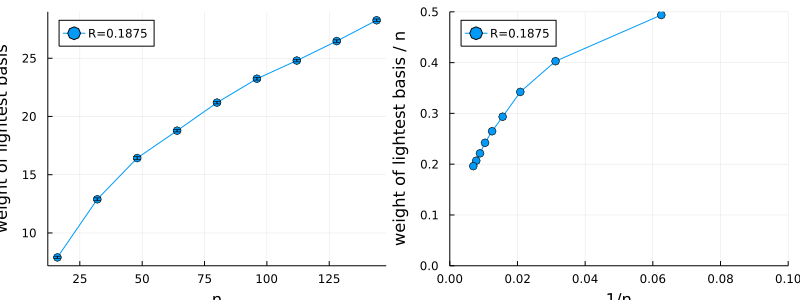

In [261]:
pl_rsb2 = plot(1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb , label="R=$(float(R_rsb))", m=:o,
    xlabel="1/n", ylabel="weight of lightest basis / n", legend=:topleft, xlims=(0, 0.1), 
    ylims=(0,0.5))
 plot(pl_rsb, pl_rsb2, size=(800,300))

In [271]:
plot(pl_rs, pl_rs2, pl_rsb, pl_rsb2, size=(800,600), dpi=300);

In [272]:
savefig("light_basis.png")

In [273]:
 plot!(deepcopy(pl_rs2), 1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb , label="R=$(float(R_rsb))", m=:o,
    xlabel="1/n", ylabel="weight of lightest basis / n", legend=:topleft, xlims=(0, 0.1), dpi=300);

In [274]:
savefig("light_basis2.png")

### Linear interpolation

In [276]:
include("../../.julia/dev/JuliaUtils/src/JuliaUtils.jl")
using .JuliaUtils

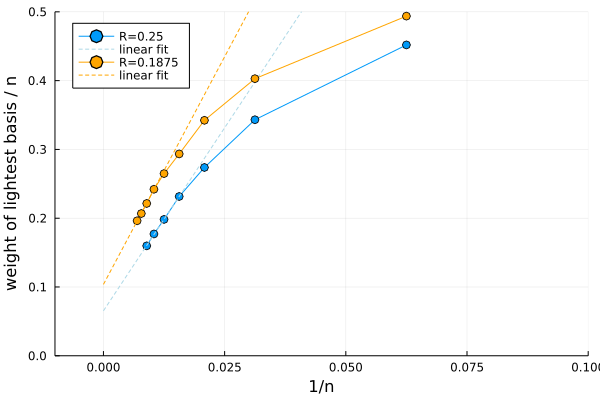

In [299]:
x = reverse(1 ./ ns_rs)
y = reverse(mean.(weights_rs) ./ ns_rs)
ls = linearls(x[1:4], y[1:4])
xrange = 0:1e-3:0.1
yhat = predict(ls, xrange)
pl3 = deepcopy(pl_rs2)
plot!(pl3, xrange, yhat, label="linear fit", ls=:dash, c=:lightblue)
x = reverse(1 ./ ns_rsb)
y = reverse(mean.(weights_rsb) ./ ns_rsb)
ls = linearls(x[1:4], y[1:4])
xrange = 0:1e-3:0.1
yhat = predict(ls, xrange)
plot!(pl3, 1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb , label="R=$(float(R_rsb))", m=:o, c=:orange)
plot!(pl3, xrange, yhat, label="linear fit", ls=:dash, c=:orange)
plot(pl3, xlims=(-0.01,0.1))